In [1]:
library(tidyverse); library(lubridate); library(readxl); library(data.table)
library(fixest)
library(rdrobust); library(broom)

Warning message:
"package 'tidyverse' was built under R version 4.3.3"
Warning message:
"package 'ggplot2' was built under R version 4.3.3"
Warning message:
"package 'forcats' was built under R version 4.3.3"
Warning message:
"package 'lubridate' was built under R version 4.3.3"
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Warning message:
"package 'readxl' was built under R version 4.3.3"
Warning message:
"package 'data.table' was built under R version 4.3.3"

Attaching package: 'data.table'


The following objects

In [2]:
usdc_raw <- read_csv("C:/Users/chris/OneDrive/桌面/毕业论文/usdc.csv")
usdt_raw <- read_csv("C:/Users/chris/OneDrive/桌面/毕业论文/usdt.csv")
mps_raw  <- read_excel("C:/Users/chris/OneDrive/桌面/毕业论文/monetary-policy-surprises-data.xlsx") 


Rows: 2606 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): snapped_at
dbl (3): price, market_cap, total_volume

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 3901 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): snapped_at
dbl (3): price, market_cap, total_volume

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### Clean data

In [3]:
mps <- mps_raw %>%
  select(Date = 1, MPS = 16) %>%   
  mutate(Date = as_date(Date)) %>%        
  filter(Date >= as_date("2018-10-05")) %>%
  drop_na(Date, MPS)
head(mps)

Date,MPS
<date>,<dbl>
2018-11-08,0.01681114
2018-12-19,0.02965432
2019-01-30,-0.01963239
2019-03-20,-0.02703320
2019-05-01,-0.03738036
2019-06-19,-0.07928805


In [4]:
mps <- mps %>%
filter(MPS > 0)
head(mps)

Date,MPS
<date>,<dbl>
2018-11-08,0.016811139
2018-12-19,0.029654324
2019-07-31,0.005759788
2019-09-18,0.044445737
2019-10-11,0.004199777
2019-10-30,0.024112085


In [5]:
nrow(mps)

[1] 34

In [6]:
usdt <- usdt_raw %>%
  select(snapped_at, total_volume) %>%
  mutate(
    date = as_date(ymd_hms(snapped_at))
  )%>%
  filter(date >= as_date("2018-10-05") & date <= as_date("2023-12-31")) %>%   
  arrange(date) %>%
  select(date, total_volume)

In [7]:
usdc <- usdc_raw %>%
  select(snapped_at, total_volume) %>%
  mutate(
    date = as_date(ymd_hms(snapped_at))
  )%>%
  filter(date >= as_date("2018-10-05") & date <= as_date("2023-12-31")) %>%   
  arrange(date) %>%
  select(date, total_volume)

In [8]:
daily_vol <- usdc %>%
  group_by(date) %>%
  summarise(volume_usdc = sum(total_volume, na.rm=TRUE)) %>%
  full_join(usdt %>% group_by(date) %>% summarise(volume_usdt = sum(total_volume, na.rm=TRUE)),
            by="date") %>%
  arrange(date)
head(daily_vol)

date,volume_usdc,volume_usdt
<date>,<dbl>,<dbl>
2018-10-05,31264.42,109163119
2018-10-06,20254.71,82904991
2018-10-07,49324.69,84072638
2018-10-08,47076.73,65173095
2018-10-09,55542.22,70625466
2018-10-10,41812.50,64067243


In [9]:
ann <- mps %>% 
    mutate(fomc_id = row_number())
head(ann)

Date,MPS,fomc_id
<date>,<dbl>,<int>
2018-11-08,0.016811139,1
2018-12-19,0.029654324,2
2019-07-31,0.005759788,3
2019-09-18,0.044445737,4
2019-10-11,0.004199777,5
2019-10-30,0.024112085,6


In [10]:
window_days <- 3
library(purrr)
ann_windows <- ann %>%
  mutate(dates = map(Date, ~ seq(.x - days(window_days), .x + days(window_days), by="day"))) %>%
  unnest(dates) %>%
  rename(date = dates) %>%
  left_join(daily_vol, by="date") %>%
  mutate(Z = as.numeric(date - Date),      # running variable in days
         D = if_else(Z >= 0, 1, 0),
         log_vol_usdc = log(volume_usdc + 1),
         log_vol_usdt = log(volume_usdt + 1)) %>%
  rename(coin_date = date) %>%
  rename(fomc_date = Date) 

In [11]:
head(ann_windows)

fomc_date,MPS,fomc_id,coin_date,volume_usdc,volume_usdt,Z,D,log_vol_usdc,log_vol_usdt
<date>,<dbl>,<int>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2018-11-08,0.01681114,1,2018-11-05,580733.6,66787759,-3,0,13.27205,18.01703
2018-11-08,0.01681114,1,2018-11-06,648445.2,48925898,-2,0,13.38233,17.70582
2018-11-08,0.01681114,1,2018-11-07,662717.4,61192288,-1,0,13.40411,17.92953
2018-11-08,0.01681114,1,2018-11-08,1008705.8,71896266,0,1,13.82418,18.09073
2018-11-08,0.01681114,1,2018-11-09,585822.1,59362584,1,1,13.28077,17.89917
2018-11-08,0.01681114,1,2018-11-10,670938.9,56743017,2,1,13.41643,17.85404


### Fit Model with clustered se

In [12]:
library(estimatr)

# Linear RD with ±3 days window
rd_df <- ann_windows %>% filter(Z >= -3 & Z <= 3)

creg1 <- lm_robust(log_vol_usdc ~ D + Z + D:Z, data = rd_df)
summary(creg1)

treg1 <- lm_robust(log_vol_usdt ~ D + Z + D:Z, data = rd_df)
summary(treg1)

Warning message:
"package 'estimatr' was built under R version 4.3.3"



Call:
lm_robust(formula = log_vol_usdc ~ D + Z + D:Z, data = rd_df)

Standard error type:  HC2 

Coefficients:
            Estimate Std. Error t value   Pr(>|t|) CI Lower CI Upper  DF
(Intercept)  20.9494     0.4934 42.4625 6.134e-112  19.9774  21.9214 234
D            -0.1502     0.5569 -0.2696  7.877e-01  -1.2474   0.9471 234
Z             0.1374     0.2248  0.6111  5.417e-01  -0.3056   0.5804 234
D:Z          -0.1701     0.2628 -0.6472  5.181e-01  -0.6879   0.3477 234

Multiple R-squared:  0.002341 ,	Adjusted R-squared:  -0.01045 
F-statistic: 0.1829 on 3 and 234 DF,  p-value: 0.908


Call:
lm_robust(formula = log_vol_usdt ~ D + Z + D:Z, data = rd_df)

Standard error type:  HC2 

Coefficients:
            Estimate Std. Error  t value   Pr(>|t|) CI Lower CI Upper  DF
(Intercept) 24.20766     0.4131 58.59525 7.931e-142  23.3937  25.0216 234
D           -0.02824     0.4736 -0.05962  9.525e-01  -0.9613   0.9048 234
Z            0.11115     0.1915  0.58055  5.621e-01  -0.2661   0.4884 234
D:Z         -0.13641     0.2286 -0.59678  5.512e-01  -0.5867   0.3139 234

Multiple R-squared:  0.003953 ,	Adjusted R-squared:  -0.008817 
F-statistic: 0.3117 on 3 and 234 DF,  p-value: 0.8169

In [13]:
#full_model
creg2 <- feols(log_vol_usdc ~ D * Z * I(Z^2) * I(Z^3), data = rd_df, cluster = ~fomc_id)
summary(creg2)

treg2 <- feols(log_vol_usdt ~ D * Z * I(Z^2) * I(Z^3), data = rd_df, cluster = ~fomc_id)
summary(treg2)

The variables 'Z:I(I(Z^2))', 'D:I(I(Z^3))', 'D:Z:I(I(Z^2))', 'D:Z:I(I(Z^3))',
'D:I(I(Z^2)):I(I(Z^3))' and 'D:Z:I(I(Z^2)):I(I(Z^3))' have been removed because
of collinearity (see $collin.var).



OLS estimation, Dep. Var.: log_vol_usdc
Observations: 238
Standard-errors: Clustered (fomc_id) 
                        Estimate Std. Error   t value   Pr(>|t|)    
(Intercept)            44.000000   4.215621  10.43737 5.4825e-12 ***
D                     -14.000000   5.694769  -2.45840 1.9373e-02 *  
Z                      29.562500   8.961637   3.29878 2.3334e-03 ** 
I(I(Z^2))              20.000000   3.355883   5.95968 1.0862e-06 ***
I(I(Z^3))               4.000000   2.107066   1.89837 6.6421e-02 .  
D:Z                   -58.000000   5.458845 -10.62496 3.4721e-12 ***
D:I(I(Z^2))           -17.750000   4.523548  -3.92391 4.1735e-04 ***
Z:I(I(Z^3))            -2.250000   0.283782  -7.92863 3.8278e-09 ***
I(I(Z^2)):I(I(Z^3))    -0.140625   0.082575  -1.70300 9.7970e-02 .  
Z:I(I(Z^2)):I(I(Z^3))   0.093750   0.017505   5.35576 6.4559e-06 ***
... 6 variables were removed because of collinearity (Z:I(I(Z^2)),
D:I(I(Z^3)) and 4 others [full set in $collin.var])
---
Signif. codes:  0 '***

The variables 'Z:I(I(Z^2))', 'D:I(I(Z^3))', 'D:Z:I(I(Z^2))', 'D:Z:I(I(Z^3))',
'D:I(I(Z^2)):I(I(Z^3))' and 'D:Z:I(I(Z^2)):I(I(Z^3))' have been removed because
of collinearity (see $collin.var).



OLS estimation, Dep. Var.: log_vol_usdt
Observations: 238
Standard-errors: Clustered (fomc_id) 
                        Estimate Std. Error   t value   Pr(>|t|)    
(Intercept)            56.000000   3.233024  17.32124  < 2.2e-16 ***
D                     -25.000000   4.482554  -5.57718 3.3563e-06 ***
Z                      42.937500   4.703652   9.12854 1.5087e-10 ***
I(I(Z^2))              36.000000   2.333412  15.42805  < 2.2e-16 ***
I(I(Z^3))               5.250000   0.996046   5.27084 8.2967e-06 ***
D:Z                   -55.000000   5.539319  -9.92902 1.9345e-11 ***
D:I(I(Z^2))           -42.000000   3.851603 -10.90455 1.7723e-12 ***
Z:I(I(Z^3))            -1.500000   0.109372 -13.71470 3.4860e-15 ***
I(I(Z^2)):I(I(Z^3))    -0.203125   0.041100  -4.94223 2.1868e-05 ***
Z:I(I(Z^2)):I(I(Z^3))   0.031250   0.018988   1.64579 1.0930e-01    
... 6 variables were removed because of collinearity (Z:I(I(Z^2)),
D:I(I(Z^3)) and 4 others [full set in $collin.var])
---
Signif. codes:  0 '***

In [19]:
#delete z3
creg2 <- feols(log_vol_usdc ~ D * Z * I(Z^2), data = rd_df, cluster = ~fomc_id)
summary(creg2)

treg2 <- feols(log_vol_usdt ~ D * Z * I(Z^2), data = rd_df, cluster = ~fomc_id)
summary(treg2)

The variable 'D:Z:I(I(Z^2))' has been removed because of collinearity (see
$collin.var).



OLS estimation, Dep. Var.: log_vol_usdc
Observations: 238
Standard-errors: Clustered (fomc_id) 
             Estimate Std. Error  t value  Pr(>|t|)    
(Intercept) 21.911421   0.633555 34.58488 < 2.2e-16 ***
D           -1.205169   0.498202 -2.41904  0.021237 *  
Z            1.633045   0.711295  2.29588  0.028172 *  
I(I(Z^2))    0.665776   0.372933  1.78524  0.083416 .  
D:Z         -1.045409   0.400736 -2.60872  0.013550 *  
D:I(I(Z^2)) -1.135981   0.671390 -1.69198  0.100073    
Z:I(I(Z^2))  0.089804   0.061131  1.46906  0.151287    
... 1 variable was removed because of collinearity (D:Z:I(I(Z^2)))
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 1.79305   Adj. R2: -0.021633

The variable 'D:Z:I(I(Z^2))' has been removed because of collinearity (see
$collin.var).



OLS estimation, Dep. Var.: log_vol_usdt
Observations: 238
Standard-errors: Clustered (fomc_id) 
             Estimate Std. Error   t value  Pr(>|t|)    
(Intercept) 24.441833   0.402079 60.788589 < 2.2e-16 ***
D           -0.284025   0.321437 -0.883611   0.38330    
Z            0.291293   0.514977  0.565642   0.57546    
I(I(Z^2))   -0.041234   0.266460 -0.154748   0.87796    
D:Z         -0.352570   0.390529 -0.902801   0.37317    
D:I(I(Z^2))  0.131104   0.443344  0.295716   0.76930    
Z:I(I(Z^2)) -0.026544   0.043423 -0.611302   0.54519    
... 1 variable was removed because of collinearity (D:Z:I(I(Z^2)))
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 1.58358   Adj. R2: -0.021101

In [17]:
usdc_eff <- data.frame(
  effect = (exp(coef(creg2)) - 1) * 100
)

usdt_eff <- data.frame(
  effect = (exp(coef(treg2)) - 1) * 100
)

# Round to 2 decimals
usdc_eff_round <- round(usdc_eff, 2)
usdt_eff_round <- round(usdt_eff, 2)
options(scipen = 999)
usdc_out <- data.frame(
  coef = coef(creg2),
  pct_change = (exp(coef(creg2)) - 1) * 100,
  p_value = pvalue(creg2)
)

usdt_out <- data.frame(
  coef = coef(treg2),
  pct_change = (exp(coef(treg2)) - 1) * 100,
  p_value = pvalue(treg2)
)

# Round everything
usdc_out <- round(usdc_out, 2)
usdt_out <- round(usdt_out, 2)

options(scipen = 999)
usdc_out
usdt_out


,coef,pct_change,p_value
,<dbl>,<dbl>,<dbl>
(Intercept),21.91,328102105963.82,0.00
D,-1.21,-70.04,0.02
Z,1.63,411.94,0.03
I(I(Z^2)),0.67,94.60,0.08
D:Z,-1.05,-64.85,0.01
D:I(I(Z^2)),-1.14,-67.89,0.10
Z:I(I(Z^2)),0.09,9.40,0.15


,coef,pct_change,p_value
,<dbl>,<dbl>,<dbl>
(Intercept),24.44,4120531343863.53,0.00
D,-0.28,-24.73,0.38
Z,0.29,33.82,0.58
I(I(Z^2)),-0.04,-4.04,0.88
D:Z,-0.35,-29.71,0.37
D:I(I(Z^2)),0.13,14.01,0.77
Z:I(I(Z^2)),-0.03,-2.62,0.55


From the regression tables, we see that USDC is more reactive to FOMC announcement dates, while USDT shows no significant response (except for the intercept).

- In the ±3-day window, USDC trading volume displays a **significant immediate drop on the announcement date, as indicated by the negative and statistically significant coefficient on D.**
The positive and significant coefficients on Z and Z² show that USDC volume accelerates in the days leading up to the announcement, while the significant negative D × Z coefficient indicates that this upward trend reverses after the event. 
The cubic term (Z³) and post-event quadratic term (D × Z²) are insignificant, suggesting no evidence of higher-order nonlinearities.


### EVENT STUDY PLOT

- If a point is above 0, it indicates higher log-volume relative to the reference day (usually the day right before the event).

- If a point is below 0, it indicates lower log-volume.

- If the CI does not cross zero, the effect is statistically significant at ~5%.

- In your plot:

    Some leads (F1, F2) are near zero → stable volume before the announcement (no pre-trend)
    Lags (L1, L2, L3) show positive or negative jumps → the immediate effect of FOMC surprises on USDC trading volume.

    For example, if L1 CI is above zero → volume significantly increases one day after the event.

- ✅ Overall: The plot visually shows how stablecoin volume responds over time around the event. Pre-trends are small, which is good for causal interpretation.

L3 and L2 are significantly negative, but L1 jumps back toward zero and becomes completely insignificant.

This pattern is not monotonic and does not show a clean downward trend.

More importantly, in event-study logic, the key test is whether all pre-event coefficients together differ from zero.

There is some movement before the event (L2, L3), but it is not consistent enough to claim a pre-trend. L1 collapses to zero.
The event caused a delayed but sizable decline in USDT volume: no anticipation, no immediate impact, but a strong negative response starting two days after the announcement.


### Robustness check with +- 1, 5 day window

In [21]:
rd_1 <- ann_windows %>% filter(Z >= -1 & Z <= 1)
c1 <- feols(log_vol_usdc ~ D * Z * I(Z^2) , data = rd_1, cluster = ~fomc_id)
summary(c1)

t1<- feols(log_vol_usdt ~ D * Z * I(Z^2) , data = rd_1, cluster = ~fomc_id)
summary(t1)

The variables 'I(I(Z^2))', 'D:Z', 'D:I(I(Z^2))', 'Z:I(I(Z^2))' and
'D:Z:I(I(Z^2))' have been removed because of collinearity (see $collin.var).



OLS estimation, Dep. Var.: log_vol_usdc
Observations: 102
Standard-errors: Clustered (fomc_id) 
             Estimate Std. Error  t value  Pr(>|t|)    
(Intercept) 21.061583   0.390930 53.87557 < 2.2e-16 ***
D           -0.355331   0.230696 -1.54026   0.13303    
Z            0.207236   0.125668  1.64907   0.10862    
... 5 variables were removed because of collinearity (I(I(Z^2)), D:Z and
3 others [full set in $collin.var])
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 1.84759   Adj. R2: -0.017936

The variables 'I(I(Z^2))', 'D:Z', 'D:I(I(Z^2))', 'Z:I(I(Z^2))' and
'D:Z:I(I(Z^2))' have been removed because of collinearity (see $collin.var).



OLS estimation, Dep. Var.: log_vol_usdt
Observations: 102
Standard-errors: Clustered (fomc_id) 
             Estimate Std. Error   t value  Pr(>|t|)    
(Intercept) 24.137899   0.274281 88.004358 < 2.2e-16 ***
D            0.019909   0.142423  0.139787   0.88968    
Z            0.002049   0.068354  0.029969   0.97627    
... 5 variables were removed because of collinearity (I(I(Z^2)), D:Z and
3 others [full set in $collin.var])
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 1.56858   Adj. R2: -0.020153

In [20]:
rd_5 <- ann_windows %>% filter(Z >= -5 & Z <= 5)
c5 <- feols(log_vol_usdc ~ D * Z * I(Z^2) , data = rd_5, cluster = ~fomc_id)
summary(c5)

t5<- feols(log_vol_usdt ~ D * Z * I(Z^2) , data = rd_5, cluster = ~fomc_id)
summary(t5)

The variable 'D:Z:I(I(Z^2))' has been removed because of collinearity (see
$collin.var).



OLS estimation, Dep. Var.: log_vol_usdc
Observations: 238
Standard-errors: Clustered (fomc_id) 
             Estimate Std. Error  t value  Pr(>|t|)    
(Intercept) 21.911421   0.633555 34.58488 < 2.2e-16 ***
D           -1.205169   0.498202 -2.41904  0.021237 *  
Z            1.633045   0.711295  2.29588  0.028172 *  
I(I(Z^2))    0.665776   0.372933  1.78524  0.083416 .  
D:Z         -1.045409   0.400736 -2.60872  0.013550 *  
D:I(I(Z^2)) -1.135981   0.671390 -1.69198  0.100073    
Z:I(I(Z^2))  0.089804   0.061131  1.46906  0.151287    
... 1 variable was removed because of collinearity (D:Z:I(I(Z^2)))
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 1.79305   Adj. R2: -0.021633

The variable 'D:Z:I(I(Z^2))' has been removed because of collinearity (see
$collin.var).



OLS estimation, Dep. Var.: log_vol_usdt
Observations: 238
Standard-errors: Clustered (fomc_id) 
             Estimate Std. Error   t value  Pr(>|t|)    
(Intercept) 24.441833   0.402079 60.788589 < 2.2e-16 ***
D           -0.284025   0.321437 -0.883611   0.38330    
Z            0.291293   0.514977  0.565642   0.57546    
I(I(Z^2))   -0.041234   0.266460 -0.154748   0.87796    
D:Z         -0.352570   0.390529 -0.902801   0.37317    
D:I(I(Z^2))  0.131104   0.443344  0.295716   0.76930    
Z:I(I(Z^2)) -0.026544   0.043423 -0.611302   0.54519    
... 1 variable was removed because of collinearity (D:Z:I(I(Z^2)))
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 1.58358   Adj. R2: -0.021101

Changing the event windows does not change much of the findings.The results are robust across ±1, ±3, and ±5 event windows.
- The USDC ±5 window gives results very similar to the ±3 window:D, Z, Z², and D×Z remain statistically significant at 5%, which reinforces the conclusion that USDC reacts meaningfully to FOMC events.
In the USDC ±1 window, only Z is positive and significant at the 5% level. As for D, there is no strong evidence of a volume jump, indicating that very short windows may not capture the full dynamics.

- Across the ±1, ±3, and ±5 windows, USDT consistently shows no statistically significant coefficients (other than the intercept). This implies USDT trading volume does not systematically respond to monetary policy announcements. 

- Overall, the evidence shows that USDC is sensitive to FOMC communications, while USDT remains largely unaffected. This difference between USDC and USDT may reflect differences in user base, liquidity structure, or issuer behavior.

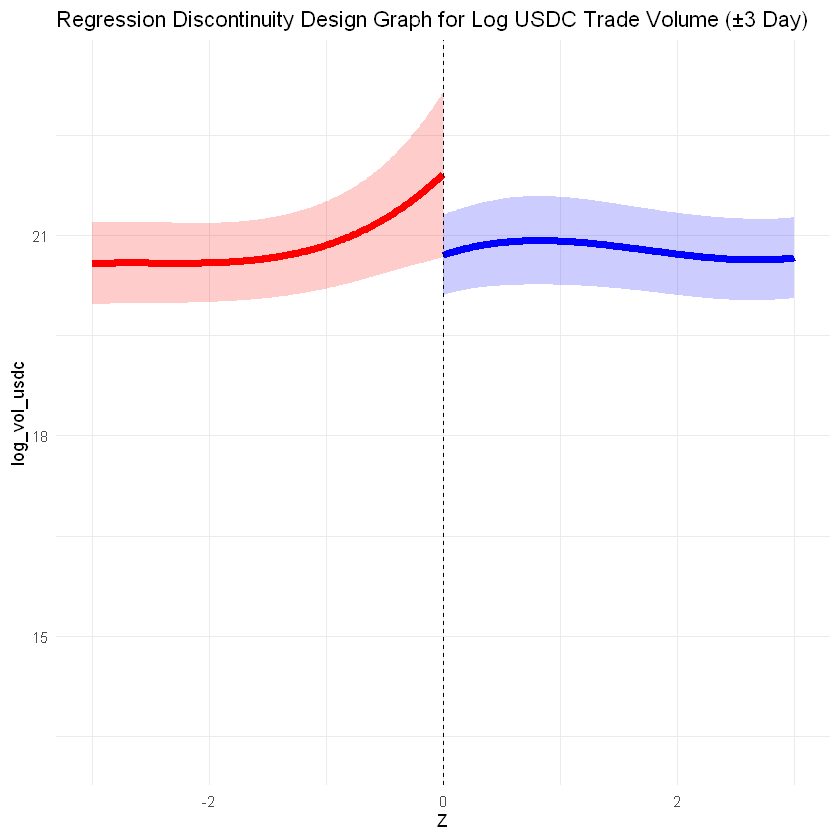

In [31]:
Z_grid_left  <- seq(min(rd_df$Z), 0, length.out = 200)
Z_grid_right <- seq(0, max(rd_df$Z), length.out = 200)

# Predict with standard errors
pred_left <- predict(creg2, newdata = data.frame(Z = Z_grid_left, D = 0), se.fit = TRUE)
pred_right <- predict(creg2, newdata = data.frame(Z = Z_grid_right, D = 1), se.fit = TRUE)

# Make data frames with upper/lower bounds
plot_left <- data.frame(
  Z = Z_grid_left,
  pred = pred_left$fit,
  lower = pred_left$fit - 1.96 * pred_left$se.fit,
  upper = pred_left$fit + 1.96 * pred_left$se.fit
)

plot_right <- data.frame(
  Z = Z_grid_right,
  pred = pred_right$fit,
  lower = pred_right$fit - 1.96 * pred_right$se.fit,
  upper = pred_right$fit + 1.96 * pred_right$se.fit
)

ggplot(rd_df, aes(x = Z)) +
  geom_point(aes(y = log_vol_usdc), alpha = 0, position = position_jitter(width = 0.01)) +
  geom_ribbon(data = plot_left, aes(ymin = lower, ymax = upper, y = pred), fill = "red", alpha = 0.2) +
  geom_line(data = plot_left, aes(y = pred), color = "red", size = 2) +
  geom_ribbon(data = plot_right, aes(ymin = lower, ymax = upper, y = pred), fill = "blue", alpha = 0.2) +
  geom_line(data = plot_right, aes(y = pred), color = "blue", size = 2) +
  geom_vline(xintercept = 0, linetype = "dashed") +
  #coord_cartesian(ylim = c(20, 27)) +
  labs(y = "log_vol_usdc", title = "Regression Discontinuity Design Graph for Log USDC Trade Volume (±3 Day)") +
  theme_minimal()


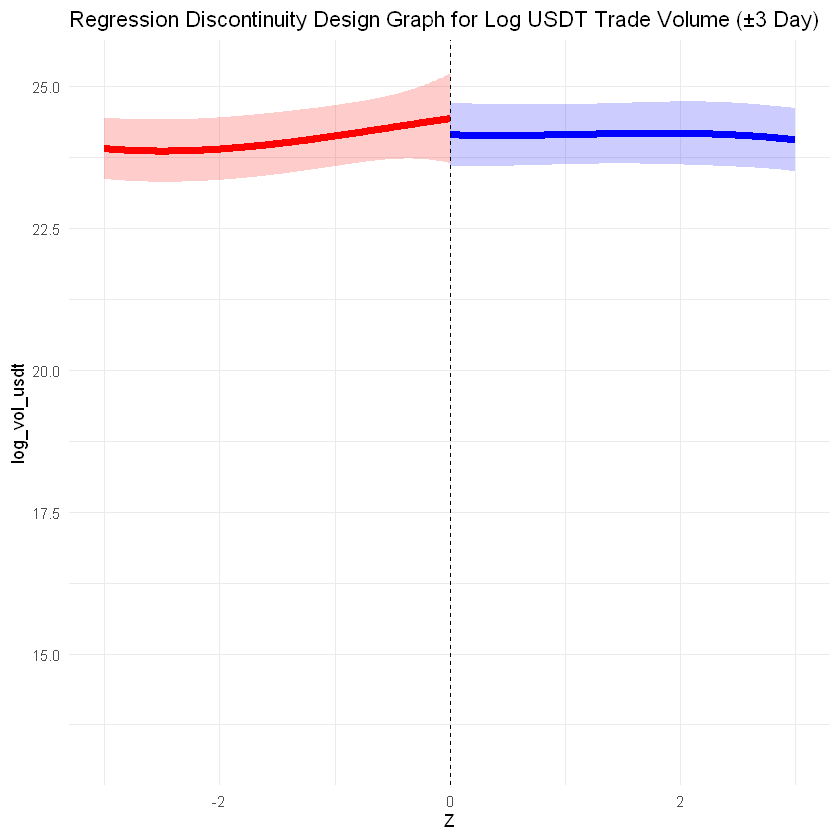

In [32]:
pred_left <- predict(treg2, newdata = data.frame(Z = Z_grid_left, D = 0), se.fit = TRUE)
pred_right <- predict(treg2, newdata = data.frame(Z = Z_grid_right, D = 1), se.fit = TRUE)

# Make data frames with upper/lower bounds
plot_left <- data.frame(
  Z = Z_grid_left,
  pred = pred_left$fit,
  lower = pred_left$fit - 1.96 * pred_left$se.fit,
  upper = pred_left$fit + 1.96 * pred_left$se.fit
)

plot_right <- data.frame(
  Z = Z_grid_right,
  pred = pred_right$fit,
  lower = pred_right$fit - 1.96 * pred_right$se.fit,
  upper = pred_right$fit + 1.96 * pred_right$se.fit
)

ggplot(rd_df, aes(x = Z)) +
  geom_point(aes(y = log_vol_usdc), alpha = 0, position = position_jitter(width = 0.01)) +
  geom_ribbon(data = plot_left, aes(ymin = lower, ymax = upper, y = pred), fill = "red", alpha = 0.2) +
  geom_line(data = plot_left, aes(y = pred), color = "red", size = 2) +
  geom_ribbon(data = plot_right, aes(ymin = lower, ymax = upper, y = pred), fill = "blue", alpha = 0.2) +
  geom_line(data = plot_right, aes(y = pred), color = "blue", size = 2) +
  geom_vline(xintercept = 0, linetype = "dashed") +
  #coord_cartesian(ylim = c(20, 27)) +
  labs(y = "log_vol_usdt", title = "Regression Discontinuity Design Graph for Log USDT Trade Volume (±3 Day)") +
  theme_minimal()
